In [1]:
#Required libraries
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random

import warnings
warnings.filterwarnings("ignore")

# View definition
def view(img):
    k = 5
    fig,ax1 = plt.subplots(figsize=(k,k))
    if len(img.shape)==2:
        ax1.imshow(img, vmin=0, vmax=255, cmap='gray')
    else:
        ax1.imshow(img)   
    plt.axis('off')
    plt.show()

## Defs to process de image

In [2]:
def imgpad(img, r):
    """ Receives and binarized image and the thikness
        wanted for the padding and returns the image
        padded
        
    Args:
        img (np array): The binarized image or array to be padded
        r (int): The thikness of the array

    Returns:
        padded (np array): The image padded
    """

    # Getting the images original shape
    nrows, ncols = img.shape

    # Creating an matrix full of zeros with the dims. of img with the desired padding
    padded = np.zeros((nrows + 2*r, ncols + 2*r), dtype = img.dtype)

    # Adding img in the center of the padded array
    padded[r:r+nrows, r:r+ncols] = img

    return padded

In [3]:
def connected_c(image):
    """ Receives a binarized image or an array of 0 and 1
        and returns the connections in the image

    Args:
        image (np array): The array of the binarized image

    Returns:
        labels (np array): The array of the binarized image
        with all the unique connections
    """

    labels = np.zeros_like(image)
    current_label = 1
    equivalences = {}

    # First pass
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] != 0:
                neighbors = []
                if i > 0 and labels[i-1, j] != 0:
                    neighbors.append(labels[i-1, j])
                if j > 0 and labels[i, j-1] != 0:
                    neighbors.append(labels[i, j-1])

                if len(neighbors) == 0:
                    labels[i, j] = current_label
                    current_label += 1
                else:
                    min_label = min(neighbors)
                    labels[i, j] = min_label
                    for neighbor in neighbors:
                        if neighbor != min_label:
                            equivalences[neighbor] = min_label

    # Second pass
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if labels[i, j] != 0:
                labels[i, j] = equivalences.get(labels[i, j], labels[i, j])

    return labels


In [4]:
def labelview(labels):
    """ Receives the labeled image to assign each label a color

    Args:
        labels (np array): The labeled image

    Returns:
        colored_labels (np array): The map of the labels with
        its color assigned
    """

    # Getting unique labels to map and assigning them to a dictionary
    unique_labels = np.unique(labels) 
    label_colors = {} 

    # Assigning a random color to every label (0 excluded)
    for label in unique_labels:
        if label == 0:
            label_colors[label] = [0, 0, 0]
        else:
            # Generating a random RGB color
            color = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
            label_colors[label] = color

    # Creating a color matrix with the colors mapping
    colored_labels = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)

    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            label = labels[i, j]
            colored_labels[i, j] = label_colors[label]

    view(colored_labels)
    return colored_labels

## Cleaning the image

In [5]:
im = cv.imread('fprint3.pgm')
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
print(imgray.shape)

(768, 768)


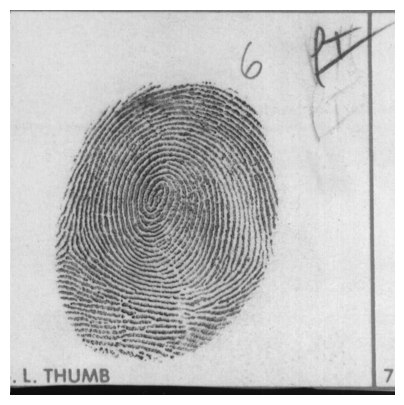

In [6]:
view(imgray)
imgray = imgpad(imgray,1)

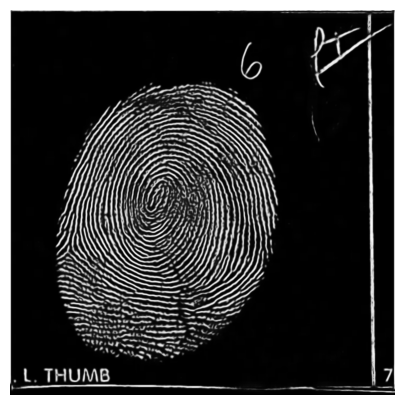

In [17]:
k = 7

img_blur = cv.GaussianBlur(imgray,(k,k),0)
cv.normalize(img_blur, img_blur, 0, 255.0, cv.NORM_MINMAX)
img_bin = 255- cv.adaptiveThreshold(img_blur, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,3,2)
img_bin = cv.fastNlMeansDenoising(img_bin, 255, 80)

view(img_bin)

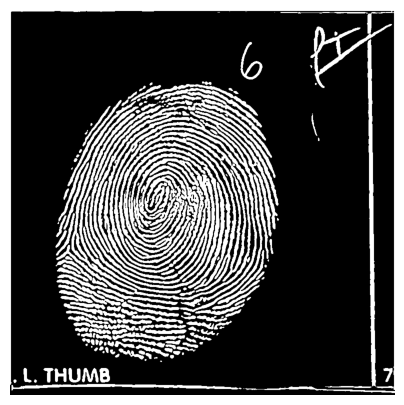

In [19]:
thresh_val = 30
binarized = cv.threshold(img_bin,thresh_val,255, cv.THRESH_BINARY)[1]
view(binarized)

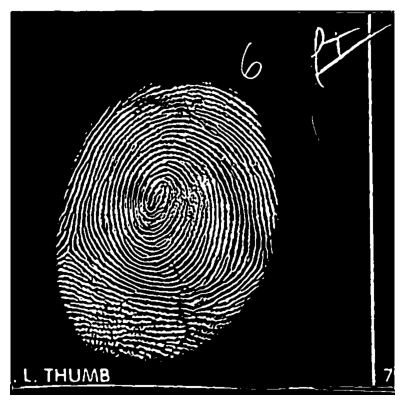

In [20]:
kernel = np.array([[  0, 255,  0],
                         [255, 255, 255],
                         [  0, 255,  0]], np.uint8)
erosion = cv.erode(binarized, kernel, iterations=1)
view(erosion)

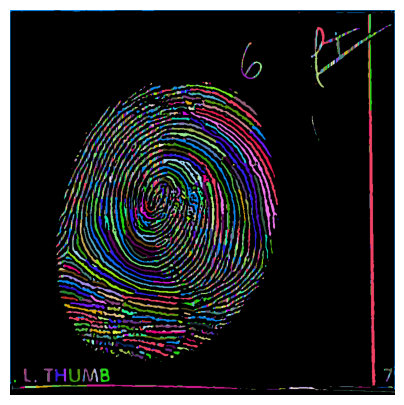

In [21]:
p1 = connected_c(erosion)
p2 = labelview(p1)